In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error

In [3]:
print("ticker names : ")
tickers = ["GOOGL","TCS","IBM"]
print(tickers)
ticker_name = int(input("enter ticker no : "))
start_date  = input("enter the start date(yyyy-mm-dd) : ").split("-")
start_date  = date(int(start_date[0]),int(start_date[1]),int(start_date[2]))
end_date    = input("enter the end date(yyyy-mm-dd) : ").split("-")
end_date    = date(int(end_date[0]),int(end_date[1]),int(end_date[2]))

ticker names : 
['GOOGL', 'TCS', 'IBM']
enter ticker no : 3
enter the start date(yyyy-mm-dd) : 2020-01-01
enter the end date(yyyy-mm-dd) : 2022-01-01


In [4]:

data = yf.download(tickers[ticker_name-1],start=start_date,end=end_date)

data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,129.063095,129.942642,128.843216,129.464630,108.749634,3293436
2020-01-03,127.695984,128.929260,127.686424,128.432129,107.882339,2482890
2020-01-06,127.552582,128.336517,127.342255,128.202682,107.689621,2537073
2020-01-07,127.810707,129.024857,127.533463,128.288712,107.761871,3232977
2020-01-08,128.594650,129.885284,128.030594,129.359467,108.661301,4545916
...,...,...,...,...,...,...
2021-12-27,130.630005,131.649994,129.949997,131.619995,122.212715,4293900
2021-12-28,131.600006,133.220001,131.589996,132.630005,123.150536,3445200
2021-12-29,132.399994,134.210007,132.300003,133.350006,123.819061,4239900


In [5]:
class Indicators():
    def __init__(self,data):
        self.data=data
        self.lst=data["Close"]
        self.data_f = pd.DataFrame(data)
        
    def moving_avg(self,col="Close",win_size=2):
        ans = self.data_f[col].rolling(window=win_size).mean()
        ans[:win_size-1] = 0
        return ans

    def exponential_moving_avg(self,col="Close",win_size=2):
        mov_avg = self.moving_avg(win_size=win_size)[win_size-1]
        smoothing = win_size/(1+len(self.data_f[col]))
        ans = []
        for i in range(len(self.data_f[col])):
            if i==0:
                ans.append((self.lst[i]*smoothing)+(mov_avg*(1-smoothing)))
            else:
                ans.append((self.lst[i]*smoothing)+(ans[i-1]*(1-smoothing)))
        return ans
    
    def moving_avg_convergence_divergence(self):
        exp_mov_avg12 = self.exponential_moving_avg(win_size=12)
        exp_mov_avg26 = self.exponential_moving_avg(win_size=26)
        ans = [exp_mov_avg12[i] - exp_mov_avg26[i] for i in range(len(self.data["Close"]))]
        return ans
    
    def relative_strength_index(self,win_size=14):
        gain,loss = [0],[0]
        for i in range(len(self.data["Close"])-1):
            diff=self.lst[i+1]-self.lst[i]
            if diff>=0:
                gain.append(diff)
                loss.append(0)
            else:
                gain.append(0)
                loss.append(abs(diff))
        ans = [0 for i in range(win_size)]
        for i in range(len(self.lst)-win_size):
            ans.append(np.mean(gain[i:i+win_size])/np.mean(loss[i:i+win_size]))
        return ans
    
    def negative_value_index(self):
        sv = self.data["Close"][0]
        ans = []
        for i in range(len(self.data["Close"])):
            if i == 0:
                ans.append(sv)
            else:
                if self.data["Volume"][i] < self.data["Volume"][i-1]:
                    r = ans[i-1]+(((self.data["Close"][i]-self.data["Close"][i-1])/self.data["Close"][i-1])*ans[i-1])
                    ans.append(r)
                else:
                    ans.append(ans[i-1])
        return ans
    def true_range(self):
        h_l = self.data["High"] - self.data["Low"]
        h_pre_close=[0]
        l_pre_close=[0]
        tr = []
        ans = []
        for i in range(len(self.data["Close"])-1):    
            h_pre_close.append(abs(self.data['High'][i+1]-self.data["Close"][i]))
            l_pre_close.append(abs(self.data['Low'][i+1]-self.data["Close"][i]))
        for i in range(len(self.data["Close"])):
            tr.append(max([h_l[i],h_pre_close[i],l_pre_close[i]]))
        n = len(self.data["Close"])
        for i in range(n):
            if i==0:
                ans.append(sum(tr)/n)
            else:
                ans.append(((ans[i-1]*(n-1))+tr[i])/n)
        return ans,tr,l_pre_close,h_pre_close,h_l
    
    def rate_of_change(self,col="Close",win_size = 12):
        ans = [0 for i in range(win_size)]
        for i in range(len(self.data["Close"])-win_size):
            ans.append(((self.data_f[col][i+(win_size-1)]-self.data_f[col][i])/self.data_f[col][i])*100)
        return ans
    
    def william_parcentage_range(self):
        high_value,low_value = max(self.data["High"]),min(self.data["Low"])
        ans = [((high_value-self.data["Close"][i])/(high_value-low_value))*-100 for i in range(len(self.data["Close"]))]
        return ans 
    
    def on_balance_value(self):
        ans=[]
        value = self.data["Volume"][0]
        ans.append(value)
        for i in range(1,len(self.data["Close"])):
            if self.data["Close"][i] > self.data["Close"][i-1]:
                value=ans[i-1]+self.data["Volume"][i]
            elif self.data["Close"][i] < self.data["Close"][i-1]:
                value=ans[i-1]-self.data["Volume"][i]
            elif self.data["Close"][i] == self.data["Close"][i-1]:
                value = ans[i-1]
            ans.append(value)
        return ans
    
    def force_index(self):
        ans = [0]
        for i in range(len(self.data["Close"])-1):
            ans.append((self.data["Close"][i+1]-self.data["Close"][i])*self.data["Volume"][i+1])
        return ans
    
    def close_volume_change(self):
        c_change,v_change = [0],[0]
        for i in range(len(self.data["Close"])-1):
            c_change.append((self.data["Close"][i+1]-self.data["Close"][i])/self.data["Close"][i+1])
            v_change.append((self.data["Volume"][i+1]-self.data["Volume"][i])/self.data["Volume"][i+1])
        return c_change,v_change
    
    def typical_price(self):
        t_price = (self.data["High"]+self.data["Low"]+self.data["Close"])/3
        return t_price
        
    def commodity_complex_index(self,win_size=20):
        typical_price_moving_avg = self.moving_avg(col="TP",win_size=20)
        mean_deviation = [0 for i in range(win_size)]
        for i in range(len(self.data)-win_size):
            q=0
            for j in range(i,i+win_size):
                q+=abs(self.data["Close"][j]-typical_price_moving_avg[i+win_size])
            mean_deviation.append(q/win_size)
        ans = [0 for i in range(win_size)]
        for i in range(win_size,len(self.data)):
            ans.append(((self.data_f["TP"][i])-typical_price_moving_avg[i])/(0.015*mean_deviation[i]))
        return ans
    
    def degree_of_variation(self,col="Close",win_size=2):
        ans = self.data[col].rolling(window=win_size).std()
        ans[:win_size-1] = 0
        return ans
    
    def true_strength_index(self):
        close_diff = [0]
        for i in range(len(self.data["Close"])-1):
            close_diff.append(self.data["Close"][i+1]-self.data["Close"][i])
        self.data_f["close_diff"] = close_diff
        close_exp_25 = self.exponential_moving_avg(col="close_diff",win_size=25)
        self.data_f["close_exp_25"] = close_exp_25
        close_exp_13 = self.exponential_moving_avg(col="close_exp_25",win_size=13)
        
        a_close_diff=[0]
        for i in range(len(self.data["Close"])-1):
            a_close_diff.append(abs(self.data["Close"][i+1])-self.data["Close"][i])
        self.data_f["a_close_diff"] = a_close_diff
        a_close_exp_25 = self.exponential_moving_avg(col="a_close_diff",win_size=25)
        self.data_f["a_close_exp_25"] = a_close_exp_25
        a_close_exp_13 = self.exponential_moving_avg(col="a_close_exp_25",win_size=13)
        
        self.data_f = self.data_f.drop(["close_diff","a_close_exp_25","a_close_diff","close_exp_25"],axis=1)
        
        ans = []
        for i in range(len(a_close_exp_13)):
            ans.append((close_exp_13[i]-a_close_exp_13[i])*100)
        return ans
    
    def upper_lower_bollinger_bound(self):
        typical_price_moving_avg = self.moving_avg(col="TP",win_size=20)
        typical_price_std = self.degree_of_variation(col="TP",win_size=20)
        upper_bound,lower_bound = [],[]
        for i in range(len(self.data["Close"])):
            upper_bound.append(typical_price_moving_avg[i]+(2*typical_price_std[i]))
            lower_bound.append(typical_price_moving_avg[i]-(2*typical_price_std[i]))
        return upper_bound,lower_bound
    
    def Average_ease_of_movement(self):
        ans = [0]
        for i in range(len(self.data["Close"])-1):
            dis_moved=((data["High"][i+1]+data["Low"][i+1])/2)-((data["High"][i]+data["Low"][i])/2)
            box_ratio=(data["Volume"][i+1]/10000000)/(data["High"][i+1]-data["Low"][i+1])
            ans.append(dis_moved/box_ratio)
        return ans
    
    def upper_lower_vortex(self,win_size=14):
        high_low,low_high = [0],[0]
        for i in range(1,len(self.data["Close"])):
            high_low.append(abs(data["High"][i]-data["Low"][i-1]))
            low_high.append(abs(data["Low"][i]-data["High"][i-1]))
        
        value_tr,value_high_low,value_low_high = [0 for i in range(win_size)],[0 for i in range(win_size)],[0 for i in range(win_size)]
        for i in range(len(self.data["Close"])-win_size):
            value_tr.append(sum(self.data_f["TR"][i:i+win_size]))
            value_high_low.append(sum(high_low[i:i+win_size]))
            value_low_high.append(sum(low_high[i:i+win_size]))
            
        vortex_p,vortex_n = [0 for i in range(win_size)],[0 for i in range(win_size)]
        for i in range(win_size,len(self.data["Close"])):
            vortex_p.append((value_high_low[i]/value_tr[i])/self.data_f["ATR"][i])
            vortex_n.append((value_low_high[i]/value_tr[i])/self.data_f["ATR"][i])
        
        return vortex_p,vortex_n
    
    def  Know_Sure_Thing(self):
        rate_moving_avg1 = self.rate_of_change(win_size=10)
        rate_moving_avg2 = self.rate_of_change(win_size=15)
        rate_moving_avg3 = self.rate_of_change(win_size=20)
        rate_moving_avg4 = self.rate_of_change(win_size=30)
        
        sum_rma = []
        for i in range(len(self.data["Close"])):
            sum_rma.append(rate_moving_avg1[i]+rate_moving_avg2[i]+rate_moving_avg3[i]+rate_moving_avg4[i])
        
        self.data_f["sum_rma"] = sum_rma
        ans = self.moving_avg(col="sum_rma",win_size=9)
        self.data_f = self.data_f.drop("sum_rma",axis=1)
        return ans
    
    def Detrended_Price_Oscillator(self,win_size=9):
        moving_avg = self.moving_avg(win_size=win_size)
        ans = [0 for i in range(win_size)]
        for i in range(len(self.data["Close"])-win_size):
            ans.append(self.data_f["Close"][i+(int(win_size/2)+1)]-moving_avg[i])
        return ans
        
    def final_df(self):
        self.data_f["MA"] = self.moving_avg()
        self.data_f["EMA"] = self.exponential_moving_avg()
        self.data_f["MACD"] = self.moving_avg_convergence_divergence()
        self.data_f["RSI"] = self.relative_strength_index()
        self.data_f["NVI"] = self.negative_value_index()
        temp = self.true_range()
        self.data_f["H_L_DIFF"] = temp[4]
        self.data_f["HIGE_PRE_CLOSE"] = temp[3]
        self.data_f["LOW_PRE_CLOSE"] = temp[2]
        self.data_f["TR"] = temp[1]
        self.data_f["ATR"] = temp[0]
        self.data_f["ROC"] = self.rate_of_change()
        self.data_f["WIL_PAR_RANGE"] = self.william_parcentage_range()
        self.data_f["OBV"] = self.on_balance_value()
        self.data_f["FI"] = self.force_index()
        self.data_f["FI5"] = self.moving_avg(col="FI",win_size=5)
        temp1 = self.close_volume_change()
        self.data_f["CLOSE_CHANGE"] = temp[0]
        self.data_f["VOLUME_CHANGE"] = temp[1]
        self.data_f["TP"] = self.typical_price()
        self.data_f["CCI"] = self.commodity_complex_index()
        self.data_f["SD"] = self.degree_of_variation()
        self.data_f["TSI"] = self.true_strength_index()
        temp3 = self.upper_lower_bollinger_bound()
        self.data_f["UB"] =temp3[0]
        self.data_f["LB"] =temp3[1]
        self.data_f["SEMV"] = self.Average_ease_of_movement()
        temp4 = self.upper_lower_vortex()
        self.data_f["VI+"] = temp[0]
        self.data_f["VI-"] = temp[1]
        self.data_f["KST"] = self.Know_Sure_Thing()
        self.data_f["DPO"] = self.Detrended_Price_Oscillator()
        return self.data_f

In [6]:
obj = Indicators(data)
data = obj.final_df()
data.head(30)

,Open,High,Low,Close,Adj Close,Volume,MA,EMA,MACD,RSI,...,CCI,SD,TSI,UB,LB,SEMV,VI+,VI-,KST,DPO
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,129.063095,129.942642,128.843216,129.464630,108.749634,3293436,0.000000,128.950420,-4.190661,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.813880,1.099426,0.000000,0.000000
2020-01-03,127.695984,128.929260,127.686424,128.432129,107.882339,2482890,128.948380,128.948371,-3.931528,0.000000,...,0.000000,0.730089,0.0,0.000000,0.000000,-5.431513,2.811830,1.778206,0.000000,0.000000
2020-01-06,127.552582,128.336517,127.342255,128.202682,107.689621,2537073,128.317406,128.945424,-3.680400,0.000000,...,0.000000,0.162243,0.0,0.000000,0.000000,-1.835850,2.808420,1.089874,0.000000,0.000000
2020-01-07,127.810707,129.024857,127.533463,128.288712,107.761871,3232977,128.245697,128.942828,-3.445720,0.000000,...,0.000000,0.060832,0.0,0.000000,0.000000,2.028705,2.805812,1.491394,0.000000,0.000000
2020-01-08,128.594650,129.885284,128.030594,129.359467,108.661301,4545916,128.824089,128.944475,-3.253806,0.000000,...,0.000000,0.757138,0.0,0.000000,0.000000,2.769356,2.803928,1.854691,0.000000,0.000000
2020-01-09,129.770554,130.774384,129.359467,130.726578,109.809677,3902208,130.043022,128.951519,-3.109931,0.000000,...,0.000000,0.966694,0.0,0.000000,0.000000,4.021116,2.801178,1.414917,0.000000,0.000000
2020-01-10,130.975143,131.806885,130.315491,130.678772,109.769516,3405148,130.702675,128.958346,-2.971572,0.000000,...,0.000000,0.033804,0.0,0.000000,0.000000,4.354693,2.798584,1.491394,0.000000,0.000000
2020-01-13,129.521988,130.630981,129.130020,130.592728,109.697227,3693426,130.635750,128.964806,-2.837434,0.000000,...,0.000000,0.060843,0.0,0.000000,0.000000,-4.798161,2.796109,1.548752,0.000000,0.000000
2020-01-14,130.286804,131.108994,129.588913,129.847031,109.070862,3850326,130.219879,128.968293,-2.689117,0.000000,...,0.000000,0.527287,0.0,0.000000,0.000000,1.849416,2.793583,1.520081,0.000000,0.000000


In [7]:
import pandas as pd
data['Target'] = data['Close']-data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['Close','Adj Close','Date'], axis=1, inplace=True)

pd.set_option('display.max_columns', None)
print(data.shape)
data.head(30)

(504, 35)


,Open,High,Low,Volume,MA,EMA,MACD,RSI,NVI,H_L_DIFF,HIGE_PRE_CLOSE,LOW_PRE_CLOSE,TR,ATR,ROC,WIL_PAR_RANGE,OBV,FI,FI5,CLOSE_CHANGE,VOLUME_CHANGE,TP,CCI,SD,TSI,UB,LB,SEMV,VI+,VI-,KST,DPO,Target,TargetClass,TargetNextClose
0,129.063095,129.942642,128.843216,3293436,0.000000,128.950420,-4.190661,0.000000,129.464630,1.099426,0.000000,0.000000,1.099426,2.813880,0.000000,-34.213227,3293436,0.000000e+00,0.000000e+00,2.813880,1.099426,129.416829,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.813880,1.099426,0.000000,0.000000,0.736145,1,128.432129
1,127.695984,128.929260,127.686424,2482890,128.948380,128.948371,-3.931528,0.000000,128.432129,1.242836,0.535370,1.778206,1.778206,2.811830,0.000000,-35.797032,810546,-2.563587e+06,0.000000e+00,2.811830,1.778206,128.349271,0.000000,0.730089,0.0,0.000000,0.000000,-5.431513,2.811830,1.778206,0.000000,0.000000,0.650101,1,128.202682
2,127.552582,128.336517,127.342255,2537073,128.317406,128.945424,-3.680400,0.000000,128.432129,0.994263,0.095612,1.089874,1.089874,2.808420,0.000000,-36.148991,-1726527,-5.821223e+05,0.000000e+00,2.808420,1.089874,127.960485,0.000000,0.162243,0.0,0.000000,0.000000,-1.835850,2.808420,1.089874,0.000000,0.000000,0.478004,1,128.288712
3,127.810707,129.024857,127.533463,3232977,128.245697,128.942828,-3.445720,0.000000,128.432129,1.491394,0.822174,0.669220,1.491394,2.805812,0.000000,-36.017027,1506450,2.781299e+05,0.000000e+00,2.805812,1.491394,128.282344,0.000000,0.060832,0.0,0.000000,0.000000,2.028705,2.805812,1.491394,0.000000,0.000000,0.764816,1,129.359467
4,128.594650,129.885284,128.030594,4545916,128.824089,128.944475,-3.253806,0.000000,128.432129,1.854691,1.596573,0.258118,1.854691,2.803928,0.000000,-34.374543,6052366,4.867562e+06,3.999966e+05,2.803928,1.854691,129.091782,0.000000,0.757138,0.0,0.000000,0.000000,2.769356,2.803928,1.854691,0.000000,0.000000,0.956024,1,130.726578
5,129.770554,130.774384,129.359467,3902208,130.043022,128.951519,-3.109931,0.000000,129.789440,1.414917,1.414917,0.000000,1.414917,2.801178,0.000000,-32.277464,9954574,5.334752e+06,1.466947e+06,2.801178,1.414917,130.286809,0.000000,0.966694,0.0,0.000000,0.000000,4.021116,2.801178,1.414917,0.000000,0.000000,-0.296371,0,130.678772
6,130.975143,131.806885,130.315491,3405148,130.702675,128.958346,-2.971572,0.000000,129.741977,1.491394,1.080307,0.411087,1.491394,2.798584,0.000000,-32.350795,6549426,-1.627858e+05,1.947107e+06,2.798584,1.491394,130.933716,0.000000,0.033804,0.0,0.000000,0.000000,4.354693,2.798584,1.491394,0.000000,0.000000,1.070740,1,130.592728
7,129.521988,130.630981,129.130020,3693426,130.635750,128.964806,-2.837434,0.000000,129.741977,1.500961,0.047791,1.548752,1.548752,2.796109,0.000000,-32.482783,2856000,-3.177983e+05,1.999972e+06,2.796109,1.548752,130.117910,0.000000,0.060843,0.0,0.000000,0.000000,-4.798161,2.796109,1.548752,0.000000,0.000000,-0.439774,0,129.847031
8,130.286804,131.108994,129.588913,3850326,130.219879,128.968293,-2.689117,0.000000,129.741977,1.520081,0.516266,1.003815,1.520081,2.793583,0.000000,-33.626644,-994326,-2.871177e+06,1.370111e+06,2.793583,1.520081,130.181646,0.000000,0.527287,0.0,0.000000,0.000000,1.849416,2.793583,1.520081,0.000000,0.000000,0.592743,1,130.611862
9,130.019119,131.988525,129.741867,4232011,130.229446,128.974790,-2.569641,0.000000,129.741977,2.246658,2.141495,0.105164,2.246658,2.792500,0.000000,-32.453432,3237685,3.236776e+06,1.043953e+06,2.792500,2.246658,130.780752,0.000000,0.540818,0.0,0.000000,0.000000,2.740592,2.792500,2.246658,0.000000,130.726578,0.630981,1,131.912048


In [8]:
sc = MinMaxScaler(feature_range=(0,1))
data1= sc.fit_transform(data)
print(data1)



[[0.64930879 0.62579908 0.68162205 ... 0.6216413  1.         0.63832894]
 [0.62632586 0.60842492 0.66296642 ... 0.61527621 1.         0.63445734]
 [0.62391508 0.59826251 0.65741598 ... 0.60254547 1.         0.63590896]
 ...
 [0.6919576  0.68198851 0.72591949 ... 0.63746202 1.         0.72131169]
 [0.70540645 0.69896189 0.7373698  ... 0.57902151 1.         0.73076091]
 [0.72810182 0.70170485 0.75398064 ... 0.54203424 0.         0.72654249]]


In [9]:
n_features = data1.shape[1]
n_features 

35

In [10]:
X = []
backcandles = 30
print(data1.shape[0])
for j in range(n_features):   #data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, data1.shape[0]):         
        X[j].append(data1[i-backcandles:i, j])

X=np.moveaxis(X, [0], [2])
X, yi =np.array(X), np.array(data1[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))


print(X)
print(X.shape)
print(y)
print(y.shape)

splitlimit = int(len(X)*0.8)
print(splitlimit)

X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

504
[[[0.64930879 0.62579908 0.68162205 ... 0.6216413  1.         0.63832894]
  [0.62632586 0.60842492 0.66296642 ... 0.61527621 1.         0.63445734]
  [0.62391508 0.59826251 0.65741598 ... 0.60254547 1.         0.63590896]
  ...
  [0.97267751 0.94214046 0.95852606 ... 0.67751049 1.         0.97660917]
  [0.95065883 0.94836908 0.97070624 ... 0.56294117 0.         0.96047752]
  [0.96062362 0.93574808 0.96901027 ... 0.30410254 0.         0.90224248]]

 [[0.62632586 0.60842492 0.66296642 ... 0.61527621 1.         0.63445734]
  [0.62391508 0.59826251 0.65741598 ... 0.60254547 1.         0.63590896]
  [0.62825451 0.6100639  0.66049959 ... 0.62376224 1.         0.65397655]
  ...
  [0.95065883 0.94836908 0.97070624 ... 0.56294117 0.         0.96047752]
  [0.96062362 0.93574808 0.96901027 ... 0.30410254 0.         0.90224248]
  [0.96142704 0.93132272 0.91288945 ... 0.65982957 1.         0.90869499]]

 [[0.62391508 0.59826251 0.65741598 ... 0.60254547 1.         0.63590896]
  [0.62825451 0.61

In [11]:
np.random.seed(10)
lstm_input = Input(shape=(backcandles, n_features), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(75, name='dense_layer1')(inputs)
inputs1= Dense(1,name='dense_layer2')(inputs)
output = Activation('linear', name='output')(inputs1)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=10, shuffle=True, validation_split = 0.1)

Epoch 1/10
23/23 [==============================] - 17s 227ms/step - loss: 0.0540 - val_loss: 0.0088
Epoch 2/10
23/23 [==============================] - 2s 96ms/step - loss: 0.0061 - val_loss: 0.0031
Epoch 3/10
23/23 [==============================] - 2s 94ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 4/10
23/23 [==============================] - 2s 94ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 5/10
23/23 [==============================] - 2s 95ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 6/10
23/23 [==============================] - 2s 98ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 7/10
23/23 [==============================] - 2s 94ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 8/10
23/23 [==============================] - 3s 111ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 9/10
23/23 [==============================] - 2s 94ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 10/10
23/23 [==============================] - 2s 97ms/step - loss: 0.0024 - val_loss: 0.0025


In [12]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test,y_pred)
print("MSE : ",mse)

3/3 [==============================] - 3s 33ms/step
MSE :  0.009460723086826456


[140.338] [133.33651733]
[138.2164] [131.95028687]
[135.94814] [132.99235535]
[135.88942] [133.47991943]
[134.72586] [133.69024658]
[135.90305] [133.70936584]
[135.18492] [132.67686462]
[134.78113] [133.27915955]
[136.17352] [132.85850525]
[135.34293] [134.16825867]


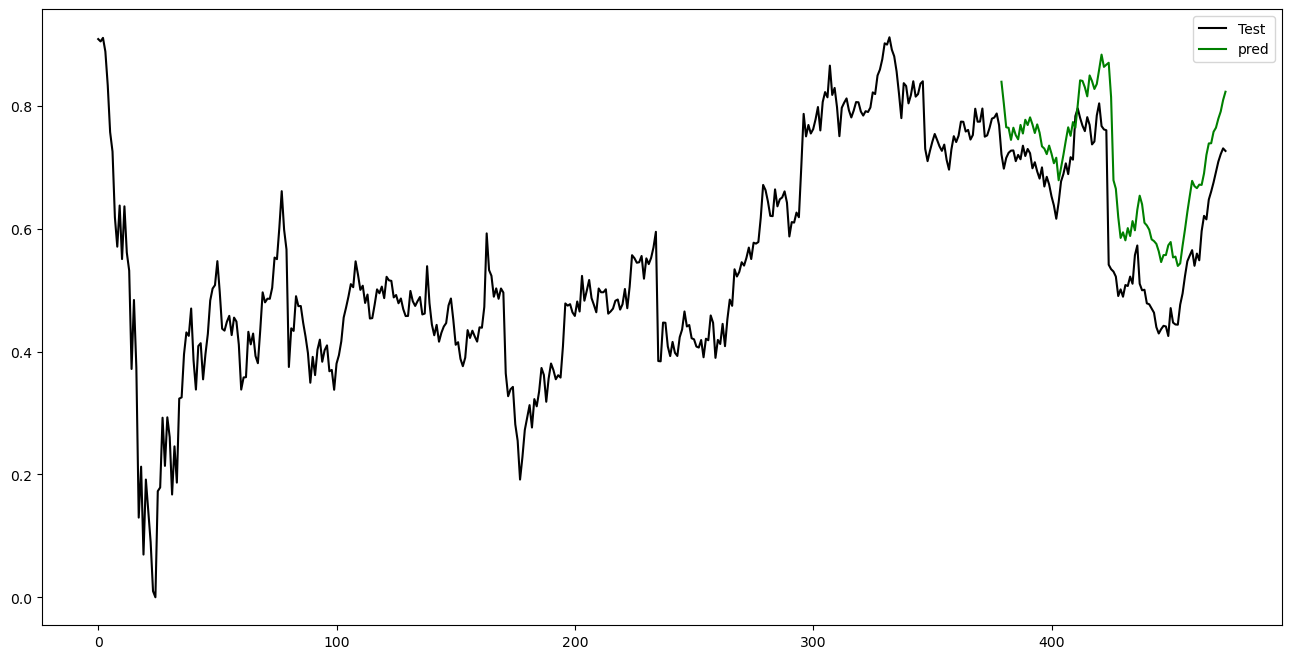

In [13]:
s=min(data["TargetNextClose"])
h=max(data["TargetNextClose"])

ns=0
nh=1    
y_pred1,y_test1 = [],[]
for i in range(len(y_pred)):
    y_pred1.append((((y_pred[i]-ns)*(h-s))/(nh-ns))+s)
    y_test1.append((((y_test[i]-ns)*(h-s))/(nh-ns))+s)
    
for i in range(10):
    print(y_pred1[i], y_test1[i])
    
    
plt.figure(figsize=(16,8))
plt.plot(y, color = 'black', label = 'Test')
plt.plot([i for i in range(splitlimit,len(y))],y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [14]:
data["TargetNextClose"]

0      128.432129
1      128.202682
2      128.288712
3      129.359467
4      130.726578
          ...    
499    131.619995
500    132.630005
501    133.350006
502    133.910004
503    133.660004
Name: TargetNextClose, Length: 504, dtype: float64

In [15]:
#ARIMA
df2 = yf.download(tickers[ticker_name-1],start=start_date,end=end_date)
df2

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,129.063095,129.942642,128.843216,129.464630,108.749641,3293436
2020-01-03,127.695984,128.929260,127.686424,128.432129,107.882347,2482890
2020-01-06,127.552582,128.336517,127.342255,128.202682,107.689606,2537073
2020-01-07,127.810707,129.024857,127.533463,128.288712,107.761894,3232977
2020-01-08,128.594650,129.885284,128.030594,129.359467,108.661293,4545916
...,...,...,...,...,...,...
2021-12-27,130.630005,131.649994,129.949997,131.619995,122.212723,4293900
2021-12-28,131.600006,133.220001,131.589996,132.630005,123.150536,3445200
2021-12-29,132.399994,134.210007,132.300003,133.350006,123.819069,4239900


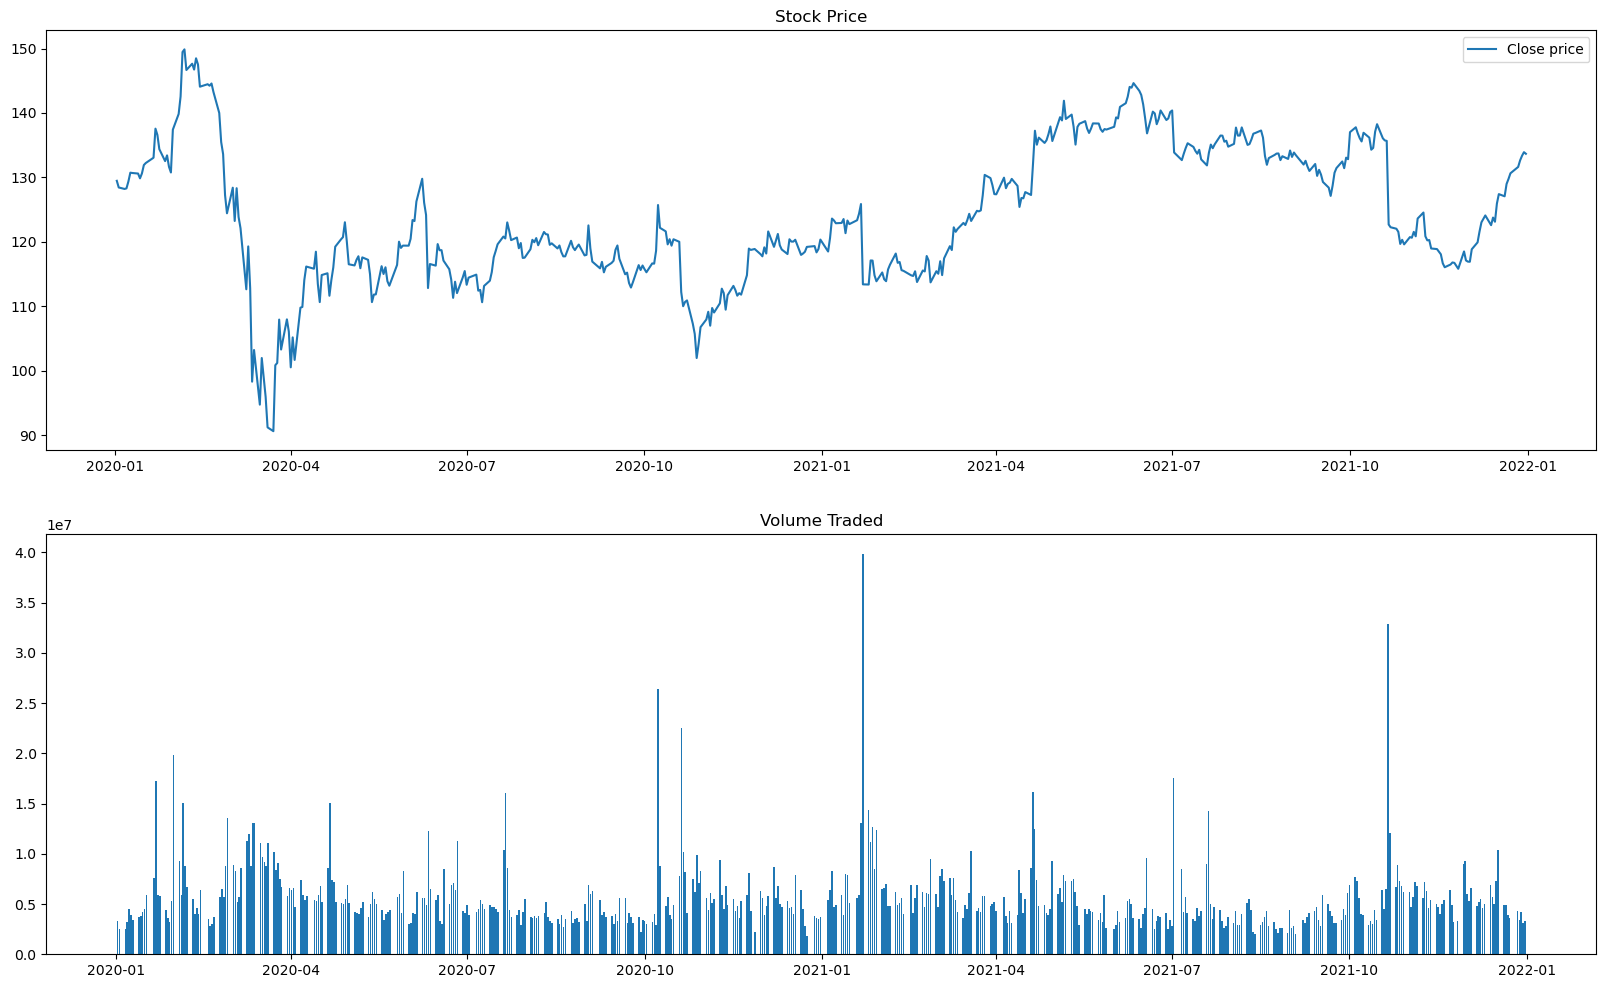

In [16]:
plt.figure(figsize=(20,12))
plt.subplot(2, 1, 1)
plt.title('Stock Price')
plt.plot(df2.Close,label='Close price')
plt.legend()
plt.subplot(2, 1, 2)
plt.title('Volume Traded')
plt.bar(x=df2.index,height=df2['Volume'])
plt.show()

In [17]:
data = list(df2["Close"])
data  

[129.46463012695312,
 128.43212890625,
 128.2026824951172,
 128.28871154785156,
 129.35946655273438,
 130.72657775878906,
 130.67877197265625,
 130.5927276611328,
 129.84703063964844,
 130.6118621826172,
 131.91204833984375,
 132.2275390625,
 133.04971313476562,
 137.5621337890625,
 136.58700561523438,
 134.3785858154297,
 132.52389526367188,
 133.41299438476562,
 131.63479614257812,
 130.75526428222656,
 137.4091796875,
 139.8374786376953,
 142.55258178710938,
 149.45506286621094,
 149.86614990234375,
 146.66348266601562,
 147.6386260986328,
 146.73040771484375,
 148.47991943359375,
 147.52389526367188,
 144.07266235351562,
 144.45506286621094,
 144.22561645507812,
 144.56979370117188,
 143.25047302246094,
 139.9904327392578,
 135.47801208496094,
 133.6042022705078,
 127.25621032714844,
 124.42638397216797,
 128.3938751220703,
 123.23136138916016,
 128.31739807128906,
 123.85277557373047,
 122.11280822753906,
 112.62906646728516,
 119.2829818725586,
 112.78202819824219,
 98.2887191772

In [165]:
# !pip install pmdarima

In [18]:
print(len(data))
x_train= data[:-100]
x_test = data[-100:]
print(len(x_train),len(x_test))

505
405 100


In [19]:
stepwise_fit = auto_arima(data,trace=True,suppress_warnings=True)
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2311.831, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2340.636, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2336.344, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2337.059, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2338.641, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2338.475, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2338.588, Time=0.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2313.678, Time=0.97 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2313.692, Time=1.56 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2337.192, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2340.371, Time=0.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2340.589, Time=0.24 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.70 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2309.838, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

In [20]:
model = sm.tsa.arima.ARIMA(data, order=(2,1,2))
model = model.fit()


In [21]:
start=len(x_train)
print(start)
end=len(data)-1
print(end)
pred = model.predict(start=start,end=end)


405
504


Date
2021-08-11    134.983145
2021-08-12    135.921373
2021-08-13    136.778558
2021-08-16    136.782677
2021-08-17    137.431404
                 ...    
2021-12-27    130.102584
2021-12-28    131.941896
2021-12-29    132.415554
2021-12-30    133.354244
2021-12-31    134.020608
Length: 100, dtype: float64


<AxesSubplot:xlabel='Date'>

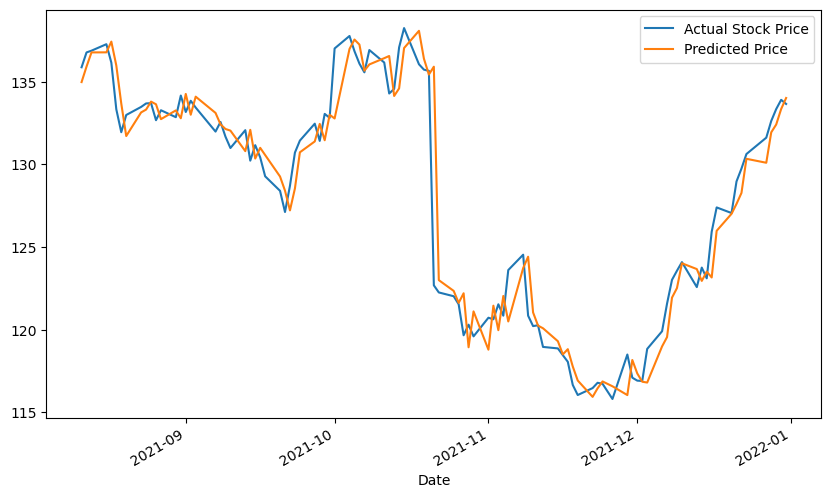

In [24]:
s = pd.Series(pred, index =df2.index[-100:])
print(s)

plt.figure(figsize=(10,6), dpi=100)
df2['Close'][-100:].plot(label='Actual Stock Price', legend=True)
s.plot(label='Predicted Price', legend=True,)

In [26]:
a=mean_squared_error(x_test,pred)

print("MSE: ",a)

MSE:  3.466178372661623
